In [1]:
import connector
import pandas as pd
import seaborn as sns
from scipy.interpolate import make_interp_spline, BSpline
from scipy.stats import skewnorm, norm, beta, uniform
import matplotlib.pyplot as plt

In [2]:
household = {
    'members': [
        {
            'name': 'sally',
            'current_salary': 50000,
            'current_age': 30,
            'gender': 'women'
        },
        {
            'name': 'harry',
            'current_salary': 30000,
            'current_age': 30,
            'gender': 'men'
        }
    ],
    'expenses': {
        'Food': 9000,
        'Housing': 23805,
        'Apparel and services': 2042,
        'Transportation': 9115,
        'Healthcare': 3163,
        'Entertainment': 2644,
        'Education': 1234
    }
}

# Income
How much money do you expect to make over your lifetime?

## Uniform Prior
Here we're assuming one's annual income increases at a constant rate

Text(0.5, 1.0, 'Uniform salary projection')

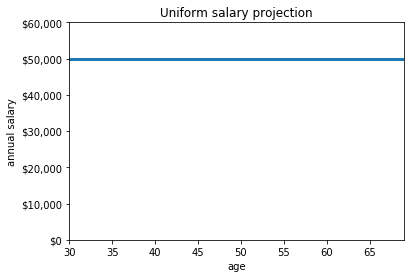

In [3]:
# Sally's lifetime earnings
age_range = range(household['members'][0]['current_age'], 70)
starting_salary = household['members'][0]['current_salary']

ax = pd.Series([uniform.rvs(loc=starting_salary, size=10000)\
           for age in age_range], index=age_range).apply(pd.Series).T.mean().plot(linewidth=3)

ax.set_ylim(0, starting_salary*1.2)
ax.set_ylabel('annual salary')
ax.set_yticklabels(['${:,}'.format(int(x)) for x in ax.get_yticks().tolist()])
ax.set_xlabel('age')
ax.set_title('Uniform salary projection')

## Normal prior
Here we assume the change in income happens at rate selected from a normal distribution with a mean of 2.5% and a standard deviation of 7.5%

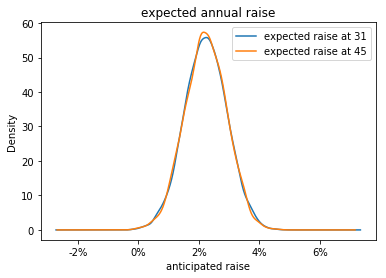

In [77]:
# Sally's lifetime earnings
age_range = range(household['members'][0]['current_age'], 70)

avg_raise = 0.025
std_raise = 0.0075

#get a dataframe of distributions at each age
normal_raises_df = pd.Series([skewnorm.rvs(-0.5, size=10000, loc=avg_raise, scale=std_raise)\
           for age in age_range], index=age_range).apply(pd.Series).T

ax = normal_raises_df[31].plot(kind='density', label='expected raise at 31')
normal_raises_df[45].plot(ax=ax, kind='density', label='expected raise at 45')
ax.set_xticklabels(['{:0.0f}%'.format(x*100) for x in ax.get_xticks().tolist()])
ax.set_xlabel('anticipated raise')
ax.set_title('expected annual raise')

ax.legend()

Text(0, 0.5, 'salary ($)')

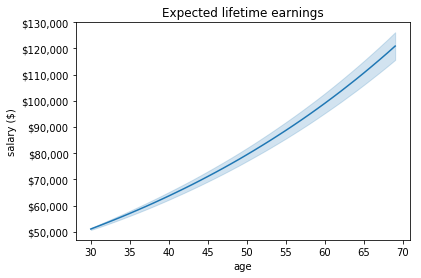

In [35]:
salary = household['members'][0]['current_salary']


ax.set_title('Expected lifetime earnings')
ax.set_yticklabels(['${:,}'.format(int(x)) for x in ax.get_yticks().tolist()])
ax.set_xlabel('age')
ax.set_ylabel('salary ($)')


ax = sns.lineplot(x='age'
                  ,y='salary'
                  ,data=pd.melt(
                    normal_raises_df\
                        .apply(lambda x: x+1)\
                        .cumprod(axis=1)\
                        .apply(lambda x: x*salary)\
                        .reset_index()
                    ,id_vars=['index']
                    ,var_name='age'
                    ,value_name='salary'
                  )
                  ,ci='sd'
    )

ax.set_title('Expected lifetime earnings')
ax.set_yticklabels(['${:,}'.format(int(x)) for x in ax.get_yticks().tolist()])
ax.set_xlabel('age')
ax.set_ylabel('salary ($)')

## bringing in outside data to update our model

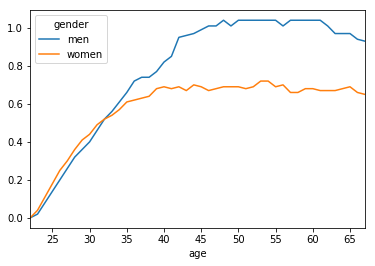

In [31]:
wage_observations_df = pd.DataFrame(connector.SheetConn('wage_data').sheet1.get_all_records())
ax = pd.pivot_table(wage_observations_df, index='age', columns='gender', values='wage_growth').plot()

In [87]:
def get_observed_wage_change(current_age, salary_at_age, gender, ending_age=65, std=0.025, size=10000, moment=-0.1):
    wages_df = wage_observations_df[(wage_observations_df['gender']==gender)&\
                         (wage_observations_df['age']>=current_age)&\
                         (wage_observations_df['age']<=ending_age)]\
        .set_index('age')['wage_growth'].pct_change()\
        .apply(lambda x: skewnorm.rvs(moment, size=size, loc=x, scale=0.05))\
        .apply(pd.Series).T
    return wages_df

observed_wage_change = get_observed_wage_change(household['members'][0]['current_age']\
                                                ,household['members'][0]['current_salary']\
                                                ,household['members'][0]['gender'])

In [88]:
observed_wage_change.head()

age,30,31,32,33,34,35,36,37,38,39,...,56,57,58,59,60,61,62,63,64,65
0,NaN,0.055942,0.087097,0.022835,0.036411,0.048251,0.079061,-0.069178,0.022400,0.070315,...,-0.099249,-0.102158,-0.086811,0.032901,-0.089812,-0.067629,-0.018966,0.048372,-0.011788,-0.019060
1,NaN,0.078876,0.036720,-0.083320,-0.060999,0.065410,0.011856,0.026147,0.013077,0.076171,...,0.100150,-0.028064,0.031136,0.014157,0.063217,0.030356,0.014821,-0.018181,0.058904,0.013947
2,NaN,0.087267,0.055864,0.113422,0.057253,0.007197,0.004893,0.071931,0.037489,0.070558,...,0.043244,-0.158010,0.024105,0.034717,-0.072003,-0.064349,0.093739,0.000473,0.101720,-0.055841
3,NaN,0.140110,0.032869,0.020647,0.121325,0.011763,-0.000673,0.010306,0.100225,0.073013,...,0.037107,-0.064587,0.002114,0.020345,0.036329,-0.086786,-0.056242,-0.003580,0.026862,0.070982
4,NaN,0.088101,0.026081,-0.045159,0.136004,0.095804,0.070976,-0.008229,0.005061,0.081250,...,-0.035689,-0.070334,0.006777,-0.026080,0.016127,-0.024445,-0.101341,0.035526,0.022019,0.032833


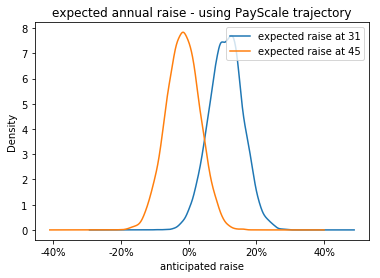

In [89]:
ax = observed_wage_change[31].plot(kind='density', label='expected raise at 31')
observed_wage_change[45].plot(ax=ax, kind='density', label='expected raise at 45')
ax.set_xticklabels(['{:0.0f}%'.format(x*100) for x in ax.get_xticks().tolist()])
ax.set_xlabel('anticipated raise')
ax.set_title('expected annual raise - using PayScale trajectory')

ax.legend(loc=1)

Text(0, 0.5, 'salary ($)')

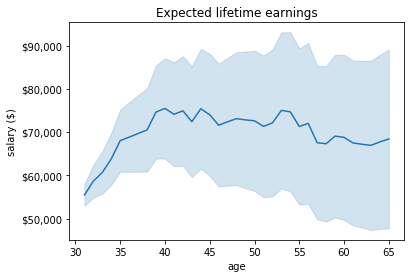

In [33]:
salary = household['members'][0]['current_salary']
ax = sns.lineplot(
    x='age'
    ,y='salary'
    ,data=pd.melt(
        observed_wage_change.apply(lambda x: x+1).cumprod(axis=1).apply(lambda x: x*salary).reset_index()
        ,id_vars=['index']
        ,var_name='age'
        ,value_name='salary'
    )
    ,ci='sd'
)

ax.set_title('Expected lifetime earnings')
ax.set_yticklabels(['${:,}'.format(int(x)) for x in ax.get_yticks().tolist()])
ax.set_xlabel('age')
ax.set_ylabel('salary ($)')

# Expenses

In [6]:
expenditure_observations_df = pd.DataFrame(connector.SheetConn('wage_data').worksheets()[4].get_all_records())

In [7]:
#it's handy to have a list to explicitly keep bins in order
ordered_cols = ['Under 25 years', '25-34 years', '35-44 years', '45-54 years', '55-64 years', \
                '65-74 years', '75 years and older']

#some of these are too granular- let's just focus on the big ones to save us having to go through
# 12 months of credit card statements trying to decide what a "postal expense" is.
valid_categories = ['Food', 'Apparel and services', 'Healthcare', 'Transportation',\
                    'Entertainment', 'Housing', 'Education', 'Average annual expenditures']

expenditure_observations_df[(expenditure_observations_df.X=='Mean')&
                            (expenditure_observations_df.category.isin(valid_categories))]\
    .set_index('category')[ordered_cols].T

category,Average annual expenditures,Food,Housing,Apparel and services,Transportation,Healthcare,Entertainment,Education
Under 25 years,33629,4759,11255,1315,6655,1547,1488,2333
25-34 years,55325,7390,19927,2042,9115,3163,2644,1234
35-44 years,69034,9376,23805,2377,11054,4348,4001,1004
45-54 years,73905,9270,23205,2308,11755,4967,4064,3213
55-64 years,64972,7894,20127,1720,10185,5777,3444,1644
65-74 years,54997,6818,18068,1420,8939,6723,3327,477
75 years and older,41849,5621,14692,866,5519,6475,1657,262


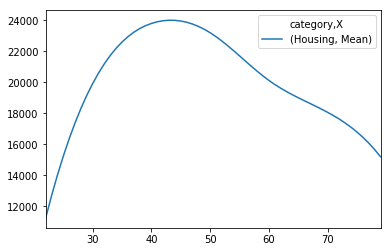

In [8]:
#We modeled income for each year so let's do the same with expenditures making some (potentially bad) assumptions:
#1. the average expenditure change for a given bucket is realized at the midpoint of that age range 
#2. the data start at 18 and end at 85
#3. the variance within the bins is consistent and constant across categories

age_bin_midpoints = {
    22: 'Under 25 years',
    30: '25-34 years',
    40: '35-44 years',
    50: '45-54 years',
    60: '55-64 years',
    70: '65-74 years',
    80: '75 years and older'
}

def get_spline_from_bin(series, degree=3):
    age_list = range(min([*age_bin_midpoints]), max([*age_bin_midpoints]))
    spline_f = make_interp_spline([*age_bin_midpoints], series.values.tolist(), k=3)
    continuous_values = spline_f(age_list)
    return pd.Series(continuous_values, index=age_list)

get_current_age_bin_f = lambda age: age_bin_midpoints[min(age_bin_midpoints.keys(), key=lambda x:abs(x-age))]

#example
category = 'Housing'
expenditure_observations_df[(expenditure_observations_df.X.isin(['Mean']))&
                                       (expenditure_observations_df.category==category)]\
    .set_index(['category', 'X'])[ordered_cols].T\
    .apply(get_spline_from_bin).plot()

In [42]:
def get_expense_liklihood(category, size=10000):
    expense_liklihoods = expenditure_observations_df[(expenditure_observations_df.X.isin(['Mean', 'SE']))&
                                       (expenditure_observations_df.category==category)]\
    .set_index(['category', 'X'])[ordered_cols].T\
    .apply(get_spline_from_bin)\
    .apply(lambda x: norm.rvs(x[0], size=size, scale=x[1]), axis=1)\
    .apply(pd.Series).T
    return expense_liklihoods

In [57]:
def get_expense_forecast(category, starting_age, expense_amount_at_starting_age, size=10000):
    expense_liklihoods = get_expense_liklihood(category)
    expense_forecast = expense_liklihoods.T.loc[starting_age:].T\
        .apply(lambda x: (1+(x - x.iat[0])/x.iat[0]) * expense_amount_at_starting_age, axis=1)
    return expense_forecast

Text(0, 0.5, 'annual spending on housing ($)')

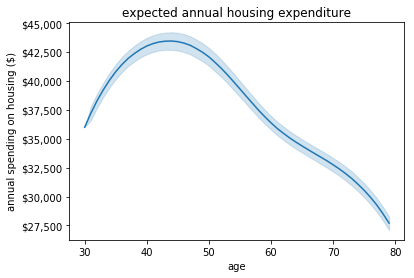

In [90]:
ax = sns.lineplot(
    x='age'\
    ,y='value'
    ,data=pd.melt(get_expense_forecast('Housing', 30, 36000).reset_index()\
                  ,id_vars=['index']\
                  ,var_name='age')
    ,ci='sd'
)

ax.set_title('expected annual housing expenditure')
ax.set_yticklabels(['${:,}'.format(int(x)) for x in ax.get_yticks().tolist()])
ax.set_xlabel('age')
ax.set_ylabel('annual spending on housing ($)')



Text(0, 0.5, 'expenses')

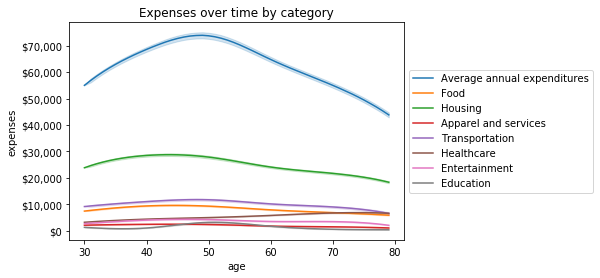

In [59]:
ax = sns.lineplot(
    x='age'\
    ,y='Average annual expenditures'
    ,data=pd.melt(get_expense_forecast('Average annual expenditures', 30, 55000).reset_index()\
                  ,id_vars=['index']\
                  ,var_name='age'\
                  ,value_name='Average annual expenditures')
    ,ci='sd'
    ,label='Average annual expenditures'
)

for category, expense_amount in household['expenses'].items():
    sns.lineplot(
    ax=ax
    ,x='age'\
    ,y=category
    ,data=pd.melt(get_expense_forecast(category, 30, expense_amount).reset_index()\
                  ,id_vars=['index']\
                  ,var_name='age'\
                  ,value_name=category)
    ,ci='sd'
    ,label=category
)

ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
ax.set_title('Expenses over time by category')

ax.set_yticklabels(['${:,}'.format(int(x)) for x in ax.get_yticks().tolist()])
ax.set_xlabel('age')
ax.set_ylabel('expenses')

In [53]:
expenses_df = pd.concat([
    pd.melt(get_expense_forecast(category, 30, expense_amount).reset_index()\
                  ,id_vars=['index']\
                  ,var_name='age'\
                  ,value_name=category)\
        .set_index(['age', 'index'])
    for category, expense_amount in household['expenses'].items()
], axis=1)

# Pay Deductions

In [104]:
tax_rate_mean = 0.25
tax_rate_std = 0.1
tax_rate_estimates = pd.Series([norm.rvs(tax_rate_mean, size=10000, scale=tax_rate_std)\
    for age in age_range], index=age_range).apply(pd.Series).T

retirement_savings_mean = 0.065
retirement_savings_std = 0.02
retirement_savings_estimates = pd.Series([norm.rvs(retirement_savings_mean, size=10000, scale=retirement_savings_std)\
       for age in age_range], index=age_range).apply(pd.Series).T



In [106]:
#tax_rate_estimates.mean()

[Text(0, 0, '24.4%'),
 Text(0, 0, '24.6%'),
 Text(0, 0, '24.8%'),
 Text(0, 0, '25.0%'),
 Text(0, 0, '25.2%'),
 Text(0, 0, '25.4%'),
 Text(0, 0, '25.6%')]

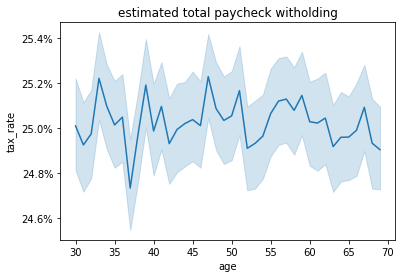

In [109]:
ax = sns.lineplot(x='age'
             ,y='tax_rate'
             ,data=pd.melt(
                 tax_rate_estimates.reset_index()
                    ,id_vars=['index']\
                    ,var_name='age'\
                    ,value_name='tax_rate'
                 )
            )
ax.set_title('estimated total paycheck witholding')
ax.set_yticklabels(['{:0.1f}%'.format(x*100.0) for x in ax.get_yticks().tolist()])

# Combining

In [65]:
household_incomes = []
for member in household['members']:
    member_wage_likelihood = get_observed_wage_change(member['current_age']\
                                                    ,member['current_salary']\
                                                    ,member['gender']
                                                   )
    member_income_df = pd.melt(
        member_wage_likelihood\
            .apply(lambda x: x+1)\
            .cumprod(axis=1)\
            .apply(lambda x: x*member['current_salary'])\
            .reset_index()
        ,id_vars=['index']
        ,var_name='age'
        ,value_name='{} salary'.format(member['name'])
    )\
    .dropna(how='any')\
    .set_index(['age', 'index'])
    household_incomes.append(member_income_df)


finances_df = pd.concat(household_incomes, axis=1)

In [66]:
finances_df = finances_df\
    .join(
        pd.melt(retirement_savings_estimates.reset_index()
            ,id_vars=['index']\
            ,var_name='age'\
            ,value_name='retirement_savings')\
        .set_index(['age', 'index'])
    )\
    .join(
        pd.melt(tax_rate_estimates.reset_index()
            ,id_vars=['index']\
            ,var_name='age'\
            ,value_name='tax_rate')\
        .set_index(['age', 'index'])
    )\
    .join(
        pd.melt(get_expense_forecast('Average annual expenditures', household['members'][0]['current_age'],\
                                 sum(household['expenses'].values())).reset_index()\
                  ,id_vars=['index']\
                  ,var_name='age'\
                  ,value_name='total_expenses')\
        .set_index(['age', 'index'])
    )

In [75]:
finances_df['additional_expenses'] = (finances_df['sally salary'] + finances_df['harry salary']) * 0.1

Text(0, 0.5, 'annual savings')

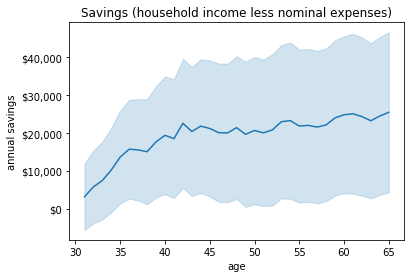

In [110]:
ax = sns.lineplot(
    x='age'
    ,y='savings'
    ,data=((finances_df['sally salary'] + finances_df['harry salary']) *\
        finances_df['tax_rate'].apply(lambda x: 1-x) *\
        finances_df['retirement_savings'].apply(lambda x: 1-x))\
    .sub(finances_df['total_expenses'] + finances_df['additional_expenses']).rename('savings').reset_index()
    ,ci='sd'
)

ax.set_title('Savings (household income less nominal expenses)')

ax.set_yticklabels(['${:,}'.format(int(x)) for x in ax.get_yticks().tolist()])
ax.set_xlabel('age')
ax.set_ylabel('annual savings')

